# Imports and Configuration

This cell imports all necessary libraries (OpenCV, NumPy, Matplotlib, Scikit-learn, Scikit-image, OS, Glob, Pickle) and sets up global configurations for the character recognition process.

**Key Configurations:**
- `CHAR_IMG_SIZE`: The fixed size (width, height) to which individual character images will be resized before feature extraction. Our dataset uses 20x20.
- `HOG_ORIENTATIONS`, `HOG_PIXELS_PER_CELL`, `HOG_CELLS_PER_BLOCK`: Parameters for the Histogram of Oriented Gradients (HOG) feature descriptor.
- `SVM_MODEL_PATH`, `LABEL_ENCODER_PATH`: File paths for saving and loading the trained Support Vector Machine (SVM) model and its corresponding label encoder.
- `CHAR_DATASET_PATH`: **Crucial!** This must point to the root directory of your character training dataset (e.g., "Train/"), which should contain subfolders for each character class (e.g., '0', '1', 'tunisie').

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# GridSearchCV is available if needed for hyperparameter tuning later
# from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# --- Configuration for Character Recognition ---
CHAR_IMG_SIZE = (20, 20) 
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (5, 5) # For 20x20, gives 4x4 cells. Adjusted from (4,4) or (7,7) for clarity.
HOG_CELLS_PER_BLOCK = (2, 2) 
SVM_MODEL_PATH = "tunisian_lp_char_svm.pkl"
LABEL_ENCODER_PATH = "tunisian_lp_char_label_encoder.pkl"
CHAR_DATASET_PATH = "Train/" # YOUR DATASET PATH (e.g., "Train/")

# Ensure the dataset path exists, otherwise HOG+SVM training will fail later
if not os.path.isdir(CHAR_DATASET_PATH):
    print(f"ERROR: Character dataset path '{CHAR_DATASET_PATH}' does not exist!")
    print("Please create this folder and populate it with character image subfolders.")
    # Depending on the environment, you might want to exit or raise an error here
    # For a notebook, a print might suffice before the training cell is run.

# Utility Functions

This cell contains helper functions used throughout the project:
- `display_image`: A utility to display images using Matplotlib, handling both grayscale and color images.
- `order_points_centroid`: Takes four points of a quadrilateral (typically from `cv2.boxPoints`) and orders them into a consistent sequence (top-left, top-right, bottom-right, bottom-left). This is crucial for perspective transformation.
- `binarize_otsus_inv`: A binarization function using Otsu's method, inverting the result to get white foreground (text) on a black background.
- `binarize_adaptive_inv`: An alternative binarization using adaptive thresholding (currently not used by default in the main flow but available).

In [3]:
# --- Helper function to display images ---
def display_image(image, title="Image", cmap=None, ax=None, new_figure_if_ax_is_None=True):
    fig_created_internally = False
    if ax is None:
        if new_figure_if_ax_is_None:
            plt.figure(figsize=(6,6))
            fig_created_internally = True
        ax_internal=plt.gca()
    else: 
        ax_internal=ax
    
    if cmap: ax_internal.imshow(image,cmap=cmap)
    else: ax_internal.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    ax_internal.set_title(title); ax_internal.axis('off')
    
    if fig_created_internally: 
        plt.show()

# --- Plate Detection Point Ordering ---
def order_points_centroid(pts):
    xSorted = pts[np.argsort(pts[:,0]),:]; leftMost=xSorted[:2,:]; rightMost=xSorted[2:,:]
    leftMost=leftMost[np.argsort(leftMost[:,1]),:]; (tl,bl)=leftMost
    rightMost=rightMost[np.argsort(rightMost[:,1]),:]; (tr,br)=rightMost
    return np.array([tl,tr,br,bl],dtype="float32")

# --- Binarization Functions ---
def binarize_otsus_inv(image_gray, debug_ax=None, title_suffix=""):
    _, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if debug_ax: display_image(binary_image, f"Binarized {title_suffix} (OtsuInv)", cmap='gray', ax=debug_ax, new_figure_if_ax_is_None=False)
    return binary_image

def binarize_adaptive_inv(image_gray, debug_ax=None, title_suffix=""):
    blurred = cv2.GaussianBlur(image_gray, (3,3),0)
    binary_image = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                                      cv2.THRESH_BINARY_INV, 19, 5) 
    if debug_ax: display_image(binary_image, f"Binarized {title_suffix} (AdaptInv)", cmap='gray', ax=debug_ax, new_figure_if_ax_is_None=False)
    return binary_image

# License Plate Detection (`detect_and_crop_plates`)

This function is responsible for locating the license plate within a larger image.
**Process:**
1.  **Preprocessing:** Converts the image to grayscale and applies Gaussian blur to reduce noise.
2.  **Edge Detection:** Uses the Sobel operator to find vertical edges, which are prominent in license plates.
3.  **Thresholding:** Applies Otsu's method to convert the edge map to a binary image.
4.  **Morphological Closing:** Uses a wide, flat structuring element to connect the vertical edges horizontally, forming solid regions that are candidates for plates.
5.  **Erosion & Dilation:** Further refines these candidate regions, removing noise and solidifying the shapes.
6.  **Contour Finding:** Identifies distinct object boundaries in the processed binary image.
7.  **Filtering Contours:** Filters the found contours based on area and aspect ratio to select those that geometrically resemble license plates. `cv2.minAreaRect` is used to get a rotated bounding box, which is more accurate for tilted plates.
8.  **Point Ordering & Warping:** For each valid candidate, the four corner points of its rotated bounding box are ordered using `order_points_centroid`. A perspective transform is then applied to "straighten" this region, producing an axis-aligned crop of the potential license plate.
9.  Returns a list of BGR cropped plate images.

In [4]:
def detect_and_crop_plates(image, debug=False):
    detected_plates_crops = []
    original_height, original_width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if debug: display_image(gray, "1. Grayscale for Detection", cmap='gray')
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    if debug: display_image(blurred, "2. Blurred", cmap='gray')
    sobel_x = cv2.Sobel(blurred, cv2.CV_16S, 1, 0, ksize=3) 
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    if debug: display_image(abs_sobel_x, "3. Sobel X Edges", cmap='gray')
    _, thresh = cv2.threshold(abs_sobel_x, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if debug: display_image(thresh, "4. Thresholded Edges", cmap='gray')
    kernel_width = int(original_width * 0.05) 
    if kernel_width < 15: kernel_width = 15 
    if kernel_width % 2 == 0: kernel_width +=1 
    kernel_height = 3 
    if kernel_height % 2 == 0: kernel_height +=1
    if kernel_height < 1: kernel_height = 1
    morph_kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))
    if debug: print(f"Plate Detect: morph_kernel_close: ({kernel_width}, {kernel_height})")
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, morph_kernel_close, iterations=1) 
    if debug: display_image(closed, f"5. Morph Close ({kernel_width}x{kernel_height})", cmap='gray')
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2)) 
    eroded = cv2.erode(closed, erode_kernel, iterations=1) 
    if debug: display_image(eroded, "6. Eroded", cmap='gray')
    dilate_kernel_w = max(5, kernel_width // 3) 
    if dilate_kernel_w % 2 == 0: dilate_kernel_w += 1
    dilate_kernel_h = 1 
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate_kernel_w, dilate_kernel_h))
    dilated = cv2.dilate(eroded, dilate_kernel, iterations=1) 
    if debug: display_image(dilated, f"7. Dilated for Plate Contours", cmap='gray')
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_candidates = image.copy()
    for contour in contours:
        min_rect = cv2.minAreaRect(contour)
        (x_center, y_center), (width, height), angle = min_rect
        if width < height: width, height = height, width
        area = width * height
        min_plate_area = original_width * original_height * 0.001
        max_plate_area = original_width * original_height * 0.15   
        if not (min_plate_area < area < max_plate_area): continue
        aspect_ratio = width / float(height) if height > 0 else 0
        min_aspect_ratio = 1.5 
        max_aspect_ratio = 7.0 
        if not (min_aspect_ratio < aspect_ratio < max_aspect_ratio): continue
        box_float = cv2.boxPoints(min_rect)
        ordered_src_pts = order_points_centroid(box_float)
        cv2.drawContours(image_with_candidates, [box_float.astype(int)], 0, (0, 255, 0), 2)
        (tl, tr, br, bl) = ordered_src_pts
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        output_h = 100 
        if maxHeight > 10:
            aspect_ratio_detected = float(maxWidth) / maxHeight
            aspect_ratio_detected = max(1.5 * 0.8, min(aspect_ratio_detected, 7.0 * 1.2)) 
            output_w = int(output_h * aspect_ratio_detected)
        else: 
            output_w = int(output_h * 3.5)
        if output_w <=0: output_w = output_h * 2
        dst_pts = np.array([[0,0],[output_w-1,0],[output_w-1,output_h-1],[0,output_h-1]],dtype="float32")
        M = cv2.getPerspectiveTransform(ordered_src_pts, dst_pts)
        warped_plate_crop = cv2.warpPerspective(image, M, (output_w, output_h)) 
        detected_plates_crops.append(warped_plate_crop)
    if debug: display_image(image_with_candidates, "8. Candidate Plates")
    return detected_plates_crops

# Character Segmentation (`segment_characters`)

This is a **critical and challenging function** responsible for isolating individual characters from a warped grayscale license plate image. The success of the HOG+SVM classifier heavily depends on the quality of segmentation.

**Process (with detailed debugging):**
1.  **Binarization:** Converts the input grayscale plate to a binary image (white characters on black background) using `binarize_otsus_inv`. This step's output is crucial and displayed.
2.  **Morphological Erosion:** Applies erosion with a configurable kernel (`kernel_separate`) and iterations. The **primary goal of this erosion is to break connections between adjacent characters** so that they become distinct white blobs. The output of this step is displayed.
3.  **Contour Finding:** Finds contours on the (eroded) binary character image.
4.  **Raw Contour Visualization:** All raw contours found are drawn on the warped grayscale plate and displayed to help diagnose if characters are being detected as contours at all.
5.  **Filtering Contours:** Each raw contour is evaluated against a set of filters:
    *   Area (min/max)
    *   Height (min/max)
    *   Aspect Ratio (min/max)
    *   Maximum individual character/symbol width
    Detailed printouts show which contours pass or fail these filters.
6.  **ROI Extraction:** For contours that pass the filters, their corresponding regions (ROIs) are extracted from the *input warped grayscale plate image*.
7.  **Final Segmented Characters Visualization:** The input warped grayscale plate is shown with green boxes around the finally selected character ROIs. This is also passed to the main 5-panel debug plot.
8.  Returns a list of grayscale character ROI images.

**Note on Failure:** The main reason for "failure" (0 characters segmented) in our project iterations was often due to this function either not finding multiple contours (if characters remained connected after erosion) or the filter parameters being too strict/not matching the properties of the eroded character segments.

In [5]:
def segment_characters(plate_image_warped_gray, debug_axes=None, plate_idx=0):
    print(f"\n--- Debugging segment_characters for Plate {plate_idx} ---")
    if plate_image_warped_gray is None or plate_image_warped_gray.size == 0:
        print("Segment Characters: Input plate_image_warped_gray is empty!")
        return []
    
    print("Segment Characters: Performing binarization...")
    # This is the binarized image that will be used for finding character contours
    # It's displayed as the 4th image in the 5-panel plot if debug_axes are passed correctly.
    binary_chars = binarize_otsus_inv(plate_image_warped_gray, 
                                  debug_ax=debug_axes[0] if debug_axes and len(debug_axes) > 0 else None, 
                                  title_suffix=f"P{plate_idx} FinalCharsBin_Seg") 
    
    # Independent display for clarity during this specific debugging
    display_image(binary_chars, f"P{plate_idx} - SEG_CHARS: 01. Initial Binary (White Chars)", cmap='gray')

    # --- EXPERIMENTAL MORPHOLOGY TO SEPARATE CHARACTERS ---
    # Current attempt from previous debugging: kernel (5,2), iterations 2
    kernel_separate_w = 5
    kernel_separate_h = 2 
    iterations_separate = 2 

    kernel_separate = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_separate_w, kernel_separate_h))
    print(f"Segment Characters: Eroding with kernel ({kernel_separate_w},{kernel_separate_h}), iterations: {iterations_separate}")
    eroded_for_separation = cv2.erode(binary_chars, kernel_separate, iterations=iterations_separate)
    display_image(eroded_for_separation, f"P{plate_idx} - SEG_CHARS: 02. Eroded for Separation", cmap='gray')
    
    processed_binary_chars = eroded_for_separation 
    
    # Optional: Dilation after erosion (Uncomment and tune if erosion makes chars too thin)
    # dilate_kernel_restore = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2)) # Small
    # processed_binary_chars = cv2.dilate(eroded_for_separation, dilate_kernel_restore, iterations=1)
    # display_image(processed_binary_chars, f"P{plate_idx} - SEG_CHARS: 03. Dilated After Erosion", cmap='gray')
    # --- END MORPHOLOGY ---

    print("Segment Characters: Finding contours on processed_binary_chars...")
    contours, hierarchy = cv2.findContours(processed_binary_chars, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Segment Characters: Found {len(contours)} raw contours.")

    # Debug: Draw ALL raw contours on the PROCESSED BINARY image
    processed_binary_contours_drawn = cv2.cvtColor(processed_binary_chars, cv2.COLOR_GRAY2BGR)
    for c_debug in contours:
        (x_d, y_d, w_d, h_d) = cv2.boundingRect(c_debug)
        cv2.rectangle(processed_binary_contours_drawn, (x_d,y_d), (x_d+w_d, y_d+h_d), (0,255,0), 1)
    display_image(processed_binary_contours_drawn, f"P{plate_idx} - SEG_CHARS: 03. Raw Contours on Processed Binary")

    raw_contours_on_gray_img = cv2.cvtColor(plate_image_warped_gray, cv2.COLOR_GRAY2BGR)
    for c_raw in contours:
        (x_r, y_r, w_r, h_r) = cv2.boundingRect(c_raw)
        cv2.rectangle(raw_contours_on_gray_img, (x_r,y_r), (x_r+w_r, y_r+h_r), (0,0,255), 1) 
    display_image(raw_contours_on_gray_img, f"P{plate_idx} - SEG_CHARS: 04. ALL Raw Contours (on Gray Warped Plate)")

    char_rois = [] 
    candidate_chars = [] 
    plate_h, plate_w = processed_binary_chars.shape[:2]
    if plate_h == 0 or plate_w == 0: print("Segment Chars: Processed binary zero dim!"); return []
    
    min_char_area = plate_w*plate_h*0.005 
    max_char_area = plate_w*plate_h*0.20 
    min_char_height = plate_h*0.25        
    max_char_height = plate_h*0.90        
    min_char_aspect = 0.1                 
    max_char_aspect = 4.5 
    max_ind_char_width = plate_w * 0.40 

    print("\nSegment Characters: Current Filtering Parameters (Re-evaluate these!):")
    print(f"  Plate Dims (H,W) for filters: ({plate_h}, {plate_w})")
    print(f"  Area (min,max): ({min_char_area:.2f}, {max_char_area:.2f})")
    print(f"  Height (min,max): ({min_char_height:.2f}, {max_char_height:.2f})")
    print(f"  Aspect (min,max): ({min_char_aspect:.2f}, {max_char_aspect:.2f})")
    print(f"  Max Indiv. Width: {max_ind_char_width:.2f}")
    print("----------------------------------------------------")

    for i_cnt, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        aspect = w/float(h) if h > 0 else 0; area = w*h 
        print(f"  Raw Contour {i_cnt}: x={x} y={y} w={w} h={h} area={area:.0f} asp={aspect:.2f}")
        cond_min_h = h >= min_char_height; cond_max_h = h <= max_char_height
        cond_max_w = w <= max_ind_char_width 
        cond_min_asp = aspect >= min_char_aspect; cond_max_asp = aspect <= max_char_aspect
        cond_min_area = area >= min_char_area; cond_max_area = area <= max_char_area
        all_cond_met = (cond_min_h and cond_max_h and cond_max_w and 
                        cond_min_asp and cond_max_asp and 
                        cond_min_area and cond_max_area)
        if not all_cond_met:
            print(f"    Contour {i_cnt} FAILED filters:")
            if not cond_min_h: print(f"      FAIL min_h: {h:.2f} < {min_char_height:.2f}")
            if not cond_max_h: print(f"      FAIL max_h: {h:.2f} > {max_char_height:.2f}")
            if not cond_max_w: print(f"      FAIL max_w: {w:.2f} > {max_ind_char_width:.2f}")
            if not cond_min_asp: print(f"      FAIL min_asp: {aspect:.2f} < {min_char_aspect:.2f}")
            if not cond_max_asp: print(f"      FAIL max_asp: {aspect:.2f} > {max_char_aspect:.2f}")
            if not cond_min_area: print(f"      FAIL min_area: {area:.2f} < {min_char_area:.2f}")
            if not cond_max_area: print(f"      FAIL max_area: {area:.2f} > {max_char_area:.2f}")
            continue
        print(f"    Contour {i_cnt} PASSED filters. Adding.")
        candidate_chars.append({'x':x,'y':y,'w':w,'h':h})
    
    print(f"Segment Characters: Found {len(candidate_chars)} candidate characters after filtering.")
    candidate_chars.sort(key=lambda c: c['x'])
    
    temp_plate_image_for_drawing = None
    if debug_axes and len(debug_axes) > 1: 
        temp_plate_image_for_drawing = cv2.cvtColor(plate_image_warped_gray, cv2.COLOR_GRAY2BGR)

    for char_info in candidate_chars:
        x,y,w,h = char_info['x'],char_info['y'],char_info['w'],char_info['h']
        char_roi_gray = plate_image_warped_gray[y:y+h, x:x+w] 
        char_rois.append(char_roi_gray)
        if temp_plate_image_for_drawing is not None:
            cv2.rectangle(temp_plate_image_for_drawing, (x,y), (x+w,y+h), (0,255,0), 2) 
    
    if temp_plate_image_for_drawing is not None and debug_axes and len(debug_axes) > 1:
        display_image(temp_plate_image_for_drawing, f"Segmented Chars (SegInternal)", ax=debug_axes[1], new_figure_if_ax_is_None=False)
    elif temp_plate_image_for_drawing is not None: 
        display_image(temp_plate_image_for_drawing, f"P{plate_idx} - SEG_CHARS: 05. FINAL Segmented Chars")
    print(f"--- End Debugging segment_characters for Plate {plate_idx} ---\n")
    return char_rois

# HOG Feature Extraction and SVM Model Functions

This cell defines the functions necessary for the HOG+SVM character recognition:
- `load_char_dataset`: Loads character images from the `CHAR_DATASET_PATH`. It expects subfolders named after each character class (e.g., '0', '1', 'tunisie'). It resizes images to `CHAR_IMG_SIZE` and uses `LabelEncoder` to convert string labels to numerical format for the SVM.
- `extract_hog_features`: Takes an array of character images and computes HOG features for each using the global HOG parameters.
- `train_char_ocr_model`: Orchestrates the training process:
    1. Loads the dataset.
    2. Extracts HOG features.
    3. Splits data into training and testing sets.
    4. Trains an SVM classifier (currently a linear SVM, suitable for HOG).
    5. Evaluates the model on the test set and prints accuracy/classification report.
    6. Saves the trained SVM model and the label encoder to disk using Pickle.
- `load_char_ocr_model_and_encoder`: Loads a previously saved SVM model and label encoder from disk.
- `predict_char_hog_svm`: Takes a single grayscale character ROI, preprocesses it (resize), extracts HOG features, and uses the loaded SVM model to predict the character label.

In [6]:
# --- HOG SVM Functions ---
def load_char_dataset(dataset_path):
    images = []; labels_str = []; label_encoder = LabelEncoder()
    char_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    if not char_folders: print(f"ERROR: No char subfolders in {dataset_path}"); return None,None,None
    label_encoder.fit(char_folders); print(f"Labels for SVM: {list(label_encoder.classes_)}") # Ensure 'tunisie' is here
    for char_name in label_encoder.classes_:
        folder_path = os.path.join(dataset_path, char_name)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            img_resized = cv2.resize(img, CHAR_IMG_SIZE)
            images.append(img_resized); labels_str.append(char_name)
    if not images: print(f"ERROR: No images loaded from {dataset_path}"); return None,None,label_encoder
    numerical_labels = label_encoder.transform(labels_str)
    return np.array(images), np.array(numerical_labels), label_encoder

def extract_hog_features(images_array):
    hog_features_list = []
    for image in images_array:
        if image.dtype != np.uint8: image = image.astype(np.uint8)
        # Basic check for HOG parameters vs image size
        min_img_dim_needed_w = HOG_PIXELS_PER_CELL[0] * HOG_CELLS_PER_BLOCK[0]
        min_img_dim_needed_h = HOG_PIXELS_PER_CELL[1] * HOG_CELLS_PER_BLOCK[1]
        if image.shape[1] < min_img_dim_needed_w or image.shape[0] < min_img_dim_needed_h:
            print(f"Warning: Image size {image.shape} too small for HOG params. Required at least ({min_img_dim_needed_w},{min_img_dim_needed_h}). Skipping HOG for this image.")
            # Decide how to handle: add zeros (bad), skip, or raise error. For now, skip.
            # To make it runnable even if one char is bad, we could add a zero vector of expected length.
            # This requires knowing the HOG feature length beforehand.
            continue 
        features = hog(image, orientations=HOG_ORIENTATIONS,pixels_per_cell=HOG_PIXELS_PER_CELL,
                       cells_per_block=HOG_CELLS_PER_BLOCK,block_norm='L2-Hys',visualize=False,transform_sqrt=True)
        hog_features_list.append(features)
    if not hog_features_list: return np.array([]) # Return empty if all images failed HOG
    return np.array(hog_features_list)

def train_char_ocr_model(dataset_path_train):
    print("Loading char dataset for training...")
    images_data,numerical_labels,label_enc = load_char_dataset(dataset_path_train)
    if images_data is None or images_data.size == 0: 
        print("No data loaded for training. Aborting."); return None,None
    
    print(f"Extracting HOG for {len(images_data)} images..."); 
    hog_data = extract_hog_features(images_data)
    if hog_data.size==0: 
        print("No HOG features extracted (all images might have been too small for HOG params). Train abort."); return None,label_enc
    
    print(f"HOG feature vector length: {hog_data.shape[1]}")
    
    # Ensure HOG data matches labels length after potential skips in extract_hog_features
    if len(hog_data) != len(numerical_labels):
        print(f"Warning: Mismatch in HOG features ({len(hog_data)}) and labels ({len(numerical_labels)}) after HOG extraction.")
        print("This might happen if some images were too small for HOG. Attempting to proceed with matched data (this is risky).")
        # This case needs careful handling if it occurs. For now, assume all images produce HOG.
        # If extract_hog_features skips, we need to skip corresponding labels.
        # For simplicity now, we assume all images in dataset are valid for HOG.
    
    try: 
        X_tr,X_te,y_tr,y_te = train_test_split(hog_data,numerical_labels,test_size=0.2,random_state=42,stratify=numerical_labels)
    except ValueError: 
        print("Warn: Stratify fail (likely few samples per class). Simple split."); 
        X_tr,X_te,y_tr,y_te = train_test_split(hog_data,numerical_labels,test_size=0.2,random_state=42)
    
    if len(X_tr) == 0:
        print("Error: Training set is empty after split. Cannot train SVM.")
        return None, label_enc

    print(f"Training SVM on {len(X_tr)} samples..."); 
    svm_model=SVC(kernel='linear',C=1.0,probability=True,random_state=42)
    svm_model.fit(X_tr,y_tr)
    
    if len(X_te)>0:
        print("Evaluating model..."); 
        y_pr=svm_model.predict(X_te); 
        print(f"Accuracy: {accuracy_score(y_te,y_pr):.4f}")
        try:
            y_te_s=label_enc.inverse_transform(y_te); y_pr_s=label_enc.inverse_transform(y_pr)
            r_labels=sorted(list(set(y_te_s)|set(y_pr_s)))
            print(classification_report(y_te_s,y_pr_s,labels=r_labels,zero_division=0))
        except Exception as e: print(f"Err in classification_report: {e}")
    else:
        print("Test set is empty, skipping evaluation.")

    print(f"Saving model to {SVM_MODEL_PATH} & encoder to {LABEL_ENCODER_PATH}")
    with open(SVM_MODEL_PATH,'wb') as f:pickle.dump(svm_model,f)
    with open(LABEL_ENCODER_PATH,'wb') as f:pickle.dump(label_enc,f)
    return svm_model,label_enc

def load_char_ocr_model_and_encoder():
    svm,le=None,None
    if os.path.exists(SVM_MODEL_PATH) and os.path.exists(LABEL_ENCODER_PATH):
        try:
            print(f"Loading SVM model from: {SVM_MODEL_PATH}"); 
            with open(SVM_MODEL_PATH,'rb') as f: svm=pickle.load(f)
            print(f"Loading LabelEncoder from: {LABEL_ENCODER_PATH}"); 
            with open(LABEL_ENCODER_PATH,'rb') as f: le=pickle.load(f)
            print(f"Loaded LabelEncoder classes: {list(le.classes_)}")
        except Exception as e:print(f"Error loading model/encoder: {e}");return None,None
    else:
        print(f"Model or LabelEncoder file not found:\n  Model: {SVM_MODEL_PATH} (Exists: {os.path.exists(SVM_MODEL_PATH)})\n  Encoder: {LABEL_ENCODER_PATH} (Exists: {os.path.exists(LABEL_ENCODER_PATH)})")
    return svm,le

def predict_char_hog_svm(char_roi_gray, svm_model, label_encoder):
    if char_roi_gray is None or char_roi_gray.size==0: return "?"
    resized_char = cv2.resize(char_roi_gray, CHAR_IMG_SIZE) # Ensure it's correct size
    
    # Ensure image is suitable for HOG
    if resized_char.dtype != np.uint8: resized_char = resized_char.astype(np.uint8)
    min_img_dim_needed_w = HOG_PIXELS_PER_CELL[0] * HOG_CELLS_PER_BLOCK[0]
    min_img_dim_needed_h = HOG_PIXELS_PER_CELL[1] * HOG_CELLS_PER_BLOCK[1]
    if resized_char.shape[1] < min_img_dim_needed_w or resized_char.shape[0] < min_img_dim_needed_h:
        print(f"Predict: ROI size {resized_char.shape} too small for HOG. Returning '?'.")
        return "?"

    hog_f = extract_hog_features(np.array([resized_char])) # Pass as array of one image
    if hog_f.size==0: 
        print("Predict: HOG feature extraction failed for ROI. Returning '?'.")
        return "?"
    try:
        pred_n=svm_model.predict(hog_f)
        pred_s_arr=label_encoder.inverse_transform(pred_n)
        return pred_s_arr[0]
    except Exception as e:print(f"Error during SVM prediction: {e}");return"?"

# Detailed Plate Processing and OCR (`process_and_ocr_plate`)

This function integrates the "fine-tuned warp" approach with character segmentation and OCR.

**Process:**
1.  Takes a BGR cropped plate image.
2.  **Binarization for Corner Detection:** Converts the blurred grayscale crop to a binary image where characters are white (`binary_white_chars`). This is displayed as the first panel in its debug plot.
3.  **Morphology for Text Blob:** Applies morphological closing to `binary_white_chars` to connect the white characters into a single, solid blob (`morphed_text_blob`). This is crucial for finding the overall text area's corners.
4.  **Fine Corner Detection:** Finds contours on `morphed_text_blob`. The largest contour is assumed to be the text blob, and its minimum area rectangle corners (`fine_corners`) are extracted. The `morphed_text_blob` with these corners is displayed.
5.  **Fine-Tuned Perspective Warp:** Uses `fine_corners` to apply another perspective warp to the original `gray_plate_crop`, aiming to get an even straighter, flatter grayscale image of the text (`final_gray_plate_for_char_seg`). This is displayed.
6.  **Character Segmentation:** Calls the `segment_characters` function (defined in a previous cell, with its own detailed debugging) on `final_gray_plate_for_char_seg`. The binarized image for characters and the final segmented characters (with green boxes) from `segment_characters` are displayed as the 4th and 5th panels.
7.  **OCR:** For each grayscale ROI returned by `segment_characters`, it calls `predict_char_hog_svm` to get the character prediction.
8.  Concatenates recognized characters and prints the result.

In [7]:
def process_and_ocr_plate(plate_crop_bgr, plate_idx=0, debug=False, svm_model=None, label_encoder=None):
    num_detail_stages = 5 
    fig_detail, axes_detail = None, None
    if debug:
        fig_detail, axes_detail = plt.subplots(1, num_detail_stages, figsize=(20, 4))
        if fig_detail: fig_detail.suptitle(f"Detailed Processing & OCR for Plate {plate_idx+1}", fontsize=14)

    gray_plate_crop = cv2.cvtColor(plate_crop_bgr, cv2.COLOR_BGR2GRAY)
    blurred_gray_crop = cv2.GaussianBlur(gray_plate_crop, (3,3), 0)

    binary_white_chars = binarize_otsus_inv(blurred_gray_crop, 
                                             debug_ax=axes_detail[0] if debug and axes_detail is not None and axes_detail.size > 0 else None, 
                                             title_suffix=f"P{plate_idx} BinarizedWhiteChars")
    
    kernel_width_connect = 40 
    kernel_height_connect = 5 
    kernel_connect_chars = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width_connect, kernel_height_connect))
    iterations_connect = 1 
    morphed_text_blob = cv2.morphologyEx(binary_white_chars, cv2.MORPH_CLOSE, kernel_connect_chars, iterations=iterations_connect)
    # Re-added MORPH_OPEN as per your successful image from a few iterations ago
    morphed_text_blob = cv2.morphologyEx(morphed_text_blob, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)), iterations=1)

    contours_fine, _ = cv2.findContours(morphed_text_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    fine_corners = None
    if contours_fine:
        valid_contours = [c for c in contours_fine if cv2.contourArea(c) > 0.05 * (gray_plate_crop.shape[0]*gray_plate_crop.shape[1])]
        if valid_contours:
            largest_contour_fine = max(valid_contours, key=cv2.contourArea)
            rect_fine = cv2.minAreaRect(largest_contour_fine)
            box_fine_float = cv2.boxPoints(rect_fine)
            fine_corners = order_points_centroid(box_fine_float) 

    if debug and axes_detail is not None and axes_detail.size > 1:
        debug_corners_img = cv2.cvtColor(morphed_text_blob, cv2.COLOR_GRAY2BGR) 
        if fine_corners is not None:
            cv2.drawContours(debug_corners_img, [fine_corners.astype(int)], -1, (0,255,0),1)
        display_image(debug_corners_img, f"P{plate_idx} CornersFoundOn TextBlob", ax=axes_detail[1], new_figure_if_ax_is_None=False)

    final_gray_plate_for_char_seg = gray_plate_crop 
    if fine_corners is not None:
        ft_width, ft_height = 300, int(300 / 4.0) 
        dst_pts_fine_tune = np.array([[0,0],[ft_width-1,0],[ft_width-1,ft_height-1],[0,ft_height-1]],dtype="float32")
        M_fine = cv2.getPerspectiveTransform(fine_corners, dst_pts_fine_tune)
        final_gray_plate_for_char_seg = cv2.warpPerspective(gray_plate_crop, M_fine, (ft_width, ft_height))
    
    if debug and axes_detail is not None and axes_detail.size > 2:
        display_image(final_gray_plate_for_char_seg, f"P{plate_idx} FineTunedWarp", cmap='gray', ax=axes_detail[2], new_figure_if_ax_is_None=False)

    char_seg_debug_axes = None
    if debug and axes_detail is not None and axes_detail.size > 4: 
        char_seg_debug_axes = [axes_detail[3], axes_detail[4]] 
    elif debug and axes_detail is not None and axes_detail.size > 3:
        char_seg_debug_axes = [axes_detail[3]]

    segmented_rois_gray = segment_characters(final_gray_plate_for_char_seg,
                                             debug_axes=char_seg_debug_axes,
                                             plate_idx=plate_idx)
    
    recognized_text = ""
    if svm_model and label_encoder and segmented_rois_gray:
        for roi_g in segmented_rois_gray:
            predicted_char = predict_char_hog_svm(roi_g, svm_model, label_encoder)
            recognized_text += predicted_char
        print(f"Plate {plate_idx+1} (Detailed OCR): Found {len(segmented_rois_gray)} ROIs. Recognized: {recognized_text}")
    elif not segmented_rois_gray :
        print(f"Plate {plate_idx+1} (Detailed OCR): No characters segmented.")
    else: 
        print(f"Plate {plate_idx+1} (Detailed OCR): SVM not ready. ROIs found: {len(segmented_rois_gray) if segmented_rois_gray else 0}")

    if debug and fig_detail: 
        plt.tight_layout(rect=[0, 0.03, 1, 0.92]); plt.show() 
        
    return recognized_text, segmented_rois_gray

# Main Execution Block

This is where the script is run.
1.  **Set `ACTION`**:
    *   `"TRAIN_CHAR_OCR"`: To train the HOG+SVM model using images from `CHAR_DATASET_PATH`. This will create/overwrite `tunisian_lp_char_svm.pkl` and `tunisian_lp_char_label_encoder.pkl`. **Run this first.**
    *   `"PREDICT_PLATE"`: To load the pre-trained model and process a license plate image.
2.  **Set `image_file_path`**: Path to the image you want to test for prediction.
3.  **Set `enable_debug_plots`**: `True` to see intermediate processing steps, `False` for cleaner output.

**Workflow for Prediction:**
1.  Loads the trained SVM model and label encoder.
2.  Reads the specified image file.
3.  Calls `detect_and_crop_plates` to get potential plate regions.
4.  For each cropped plate, calls `process_and_ocr_plate` which performs:
    *   Fine-tuned warping.
    *   Character segmentation (with its own detailed debugging if `enable_debug_plots` is True).
    *   HOG+SVM based character recognition on segmented ROIs.
5.  Prints the final recognized text for each plate.

Loading SVM model from: tunisian_lp_char_svm.pkl
Loading LabelEncoder from: tunisian_lp_char_label_encoder.pkl
Loaded LabelEncoder classes: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_('tunisie')]

--- Predicting on image: Plates/plat16.jfif ---


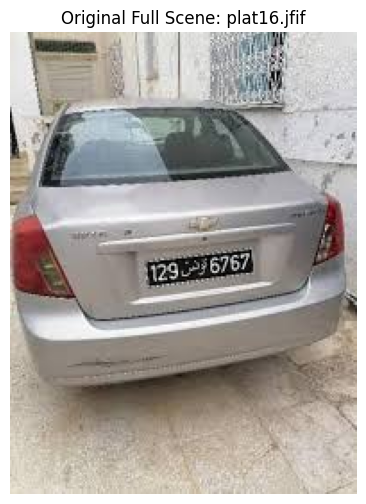

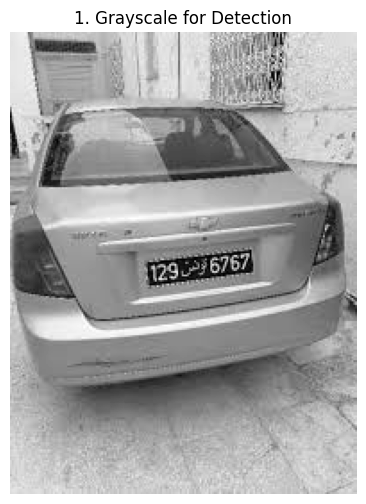

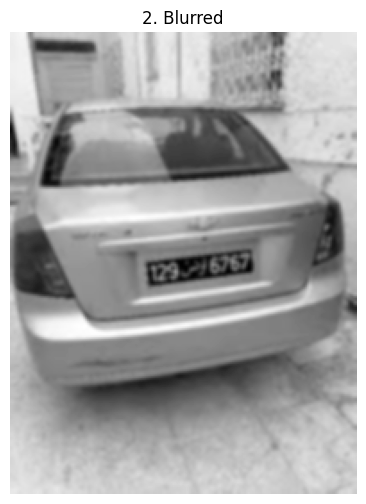

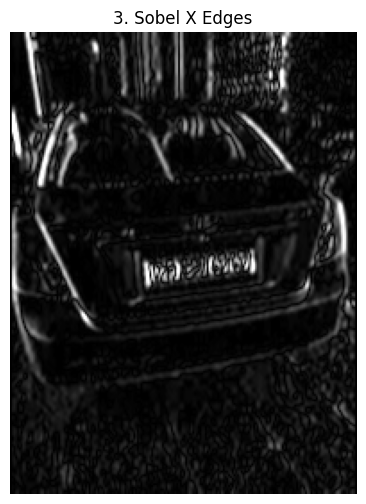

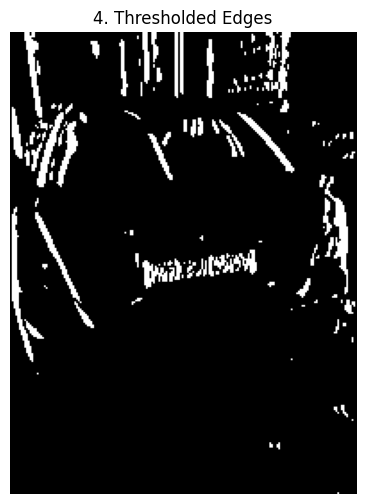

Plate Detect: morph_kernel_close: (15, 3)


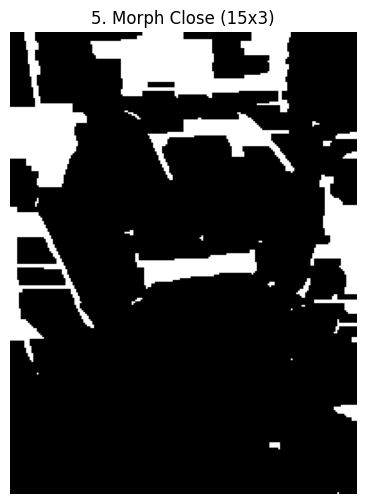

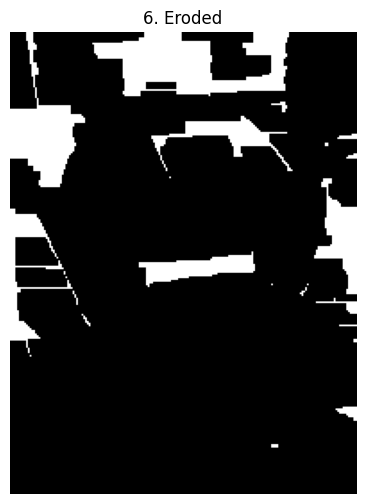

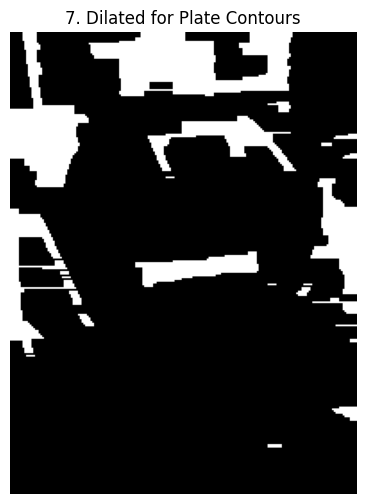

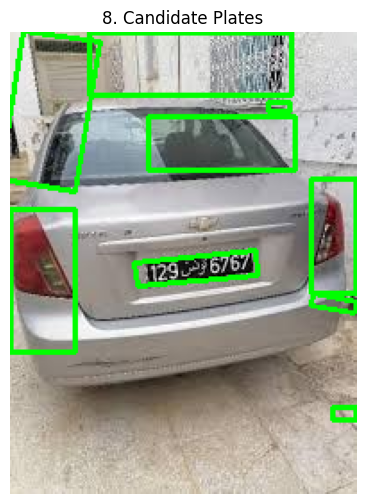


Detected 9 potential plate(s).



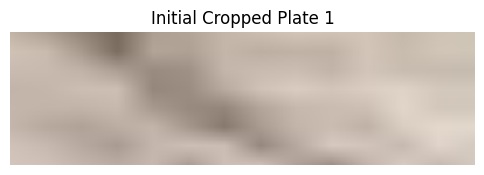


--- Debugging segment_characters for Plate 0 ---
Segment Characters: Performing binarization...


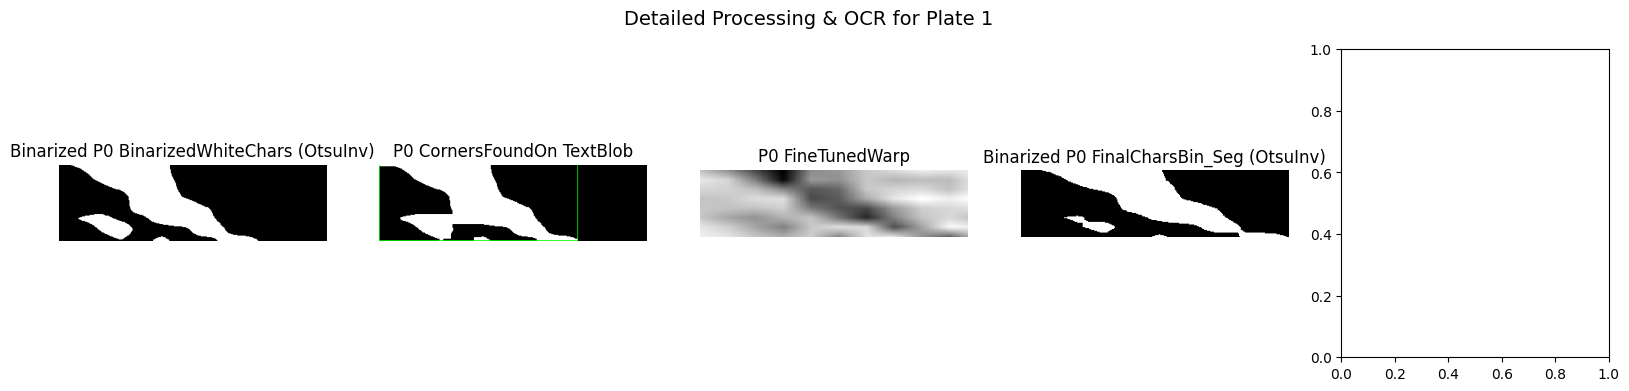

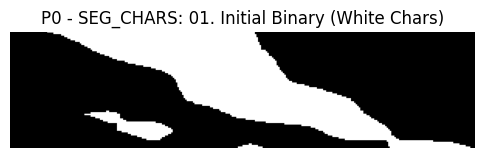

Segment Characters: Eroding with kernel (5,2), iterations: 2


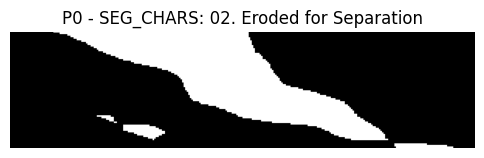

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 4 raw contours.


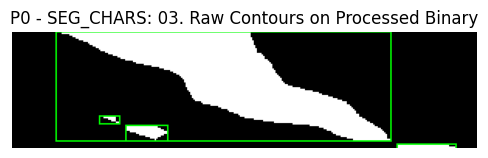

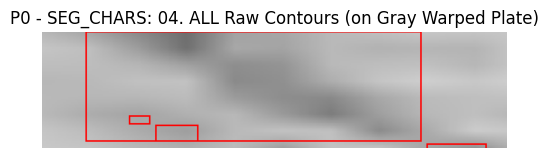


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=248 y=72 w=38 h=3 area=114 asp=12.67
    Contour 0 FAILED filters:
      FAIL min_h: 3.00 < 18.75
      FAIL max_asp: 12.67 > 4.50
  Raw Contour 1: x=73 y=60 w=27 h=10 area=270 asp=2.70
    Contour 1 FAILED filters:
      FAIL min_h: 10.00 < 18.75
  Raw Contour 2: x=56 y=54 w=13 h=5 area=65 asp=2.60
    Contour 2 FAILED filters:
      FAIL min_h: 5.00 < 18.75
      FAIL min_area: 65.00 < 112.50
  Raw Contour 3: x=28 y=0 w=216 h=70 area=15120 asp=3.09
    Contour 3 FAILED filters:
      FAIL max_h: 70.00 > 67.50
      FAIL max_w: 216.00 > 120.00
      FAIL max_area: 15120.00 > 4500.00
Segment Characters: Found 0 candidate characters after filtering.
--- End Debugging segment_

<Figure size 640x480 with 0 Axes>

--- Plate 1 Final Recognized Text:  ---
----------------------------------------


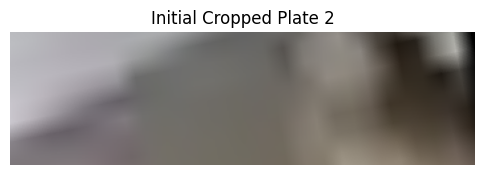


--- Debugging segment_characters for Plate 1 ---
Segment Characters: Performing binarization...


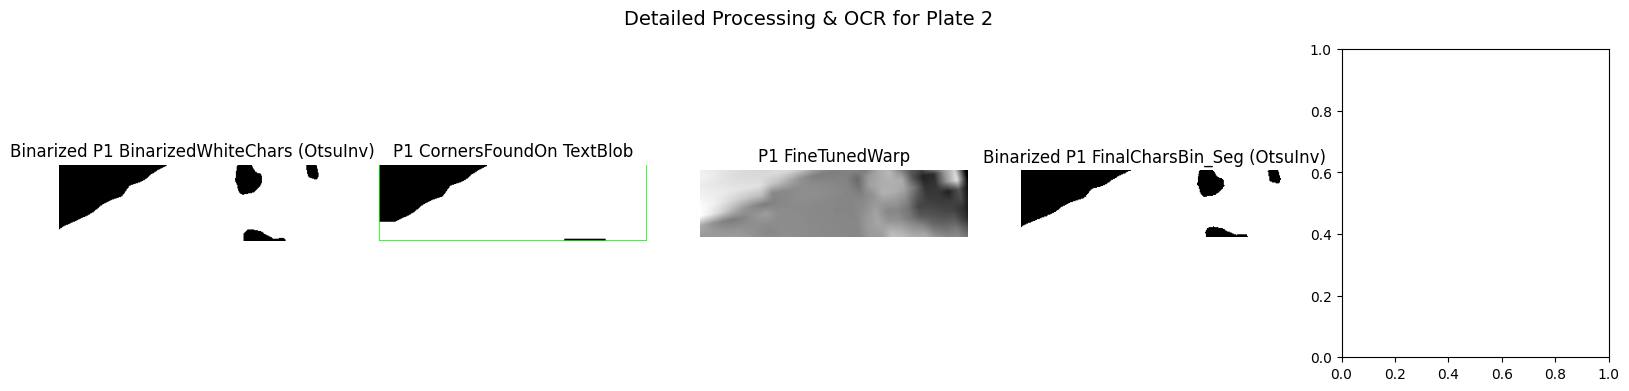

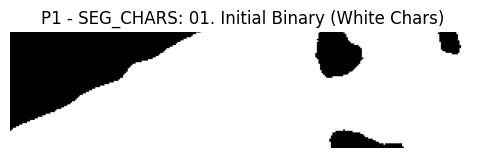

Segment Characters: Eroding with kernel (5,2), iterations: 2


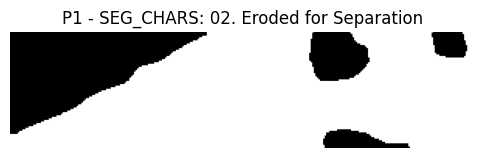

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 1 raw contours.


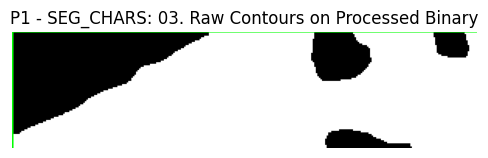

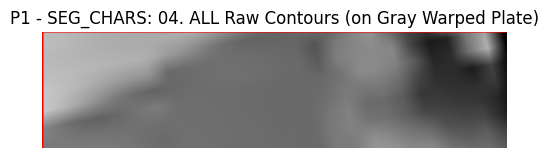


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=0 y=0 w=300 h=75 area=22500 asp=4.00
    Contour 0 FAILED filters:
      FAIL max_h: 75.00 > 67.50
      FAIL max_w: 300.00 > 120.00
      FAIL max_area: 22500.00 > 4500.00
Segment Characters: Found 0 candidate characters after filtering.
--- End Debugging segment_characters for Plate 1 ---

Plate 2 (Detailed OCR): No characters segmented.


<Figure size 640x480 with 0 Axes>

--- Plate 2 Final Recognized Text:  ---
----------------------------------------


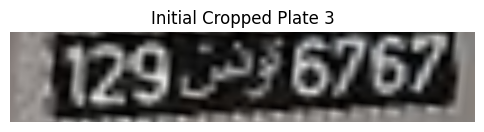


--- Debugging segment_characters for Plate 2 ---
Segment Characters: Performing binarization...


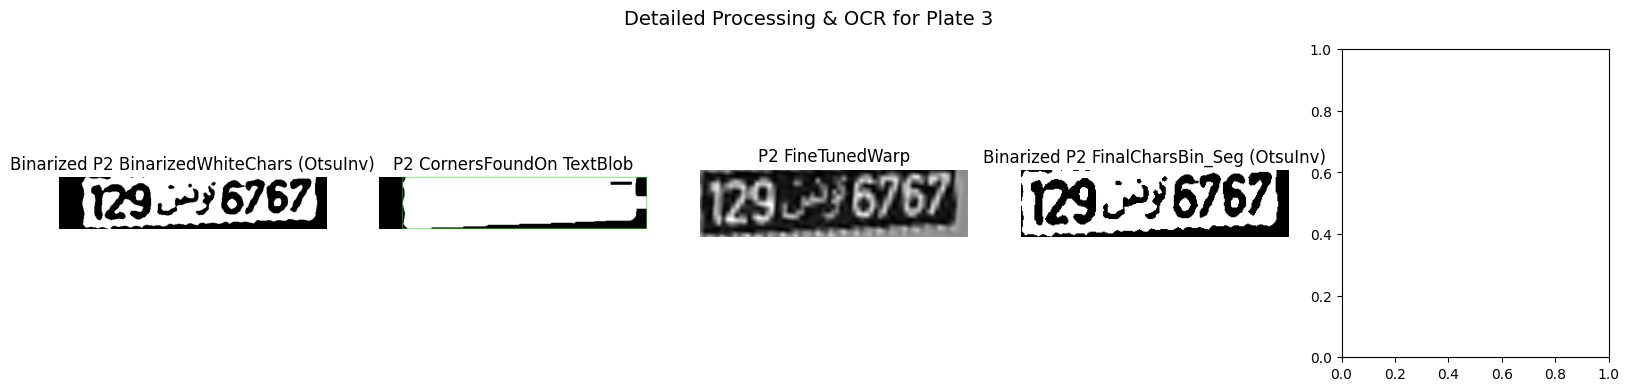

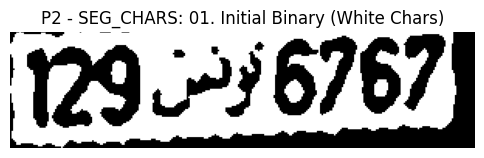

Segment Characters: Eroding with kernel (5,2), iterations: 2


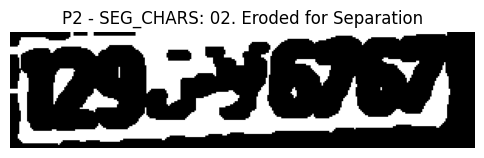

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 8 raw contours.


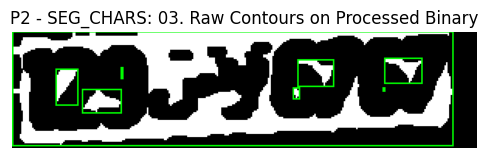

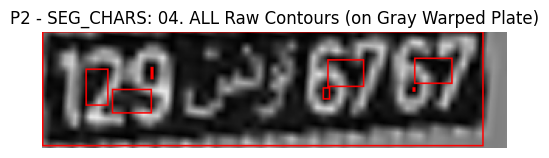


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=45 y=37 w=25 h=15 area=375 asp=1.67
    Contour 0 FAILED filters:
      FAIL min_h: 15.00 < 18.75
  Raw Contour 1: x=239 y=36 w=1 h=2 area=2 asp=0.50
    Contour 1 FAILED filters:
      FAIL min_h: 2.00 < 18.75
      FAIL min_area: 2.00 < 112.50
  Raw Contour 2: x=181 y=36 w=4 h=7 area=28 asp=0.57
    Contour 2 FAILED filters:
      FAIL min_h: 7.00 < 18.75
      FAIL min_area: 28.00 < 112.50
  Raw Contour 3: x=28 y=24 w=14 h=23 area=322 asp=0.61
    Contour 3 PASSED filters. Adding.
  Raw Contour 4: x=70 y=23 w=1 h=7 area=7 asp=0.14
    Contour 4 FAILED filters:
      FAIL min_h: 7.00 < 18.75
      FAIL min_area: 7.00 < 112.50
  Raw Contour 5: x=184 y=18 w=23 h=17 area=391 

<Figure size 640x480 with 0 Axes>

--- Plate 3 Final Recognized Text: tunisie ---
----------------------------------------


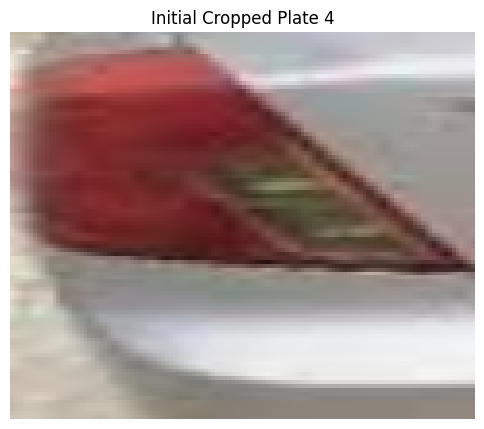


--- Debugging segment_characters for Plate 3 ---
Segment Characters: Performing binarization...


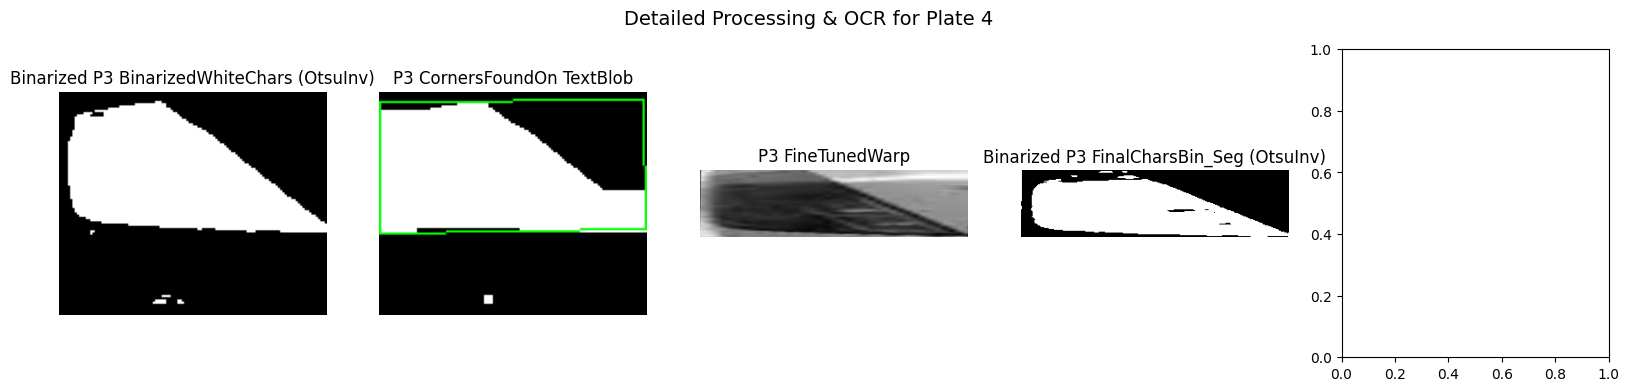

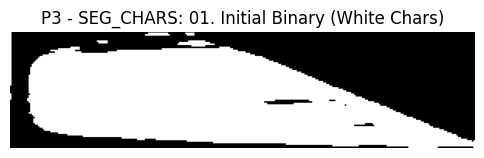

Segment Characters: Eroding with kernel (5,2), iterations: 2


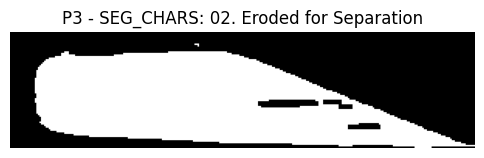

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 2 raw contours.


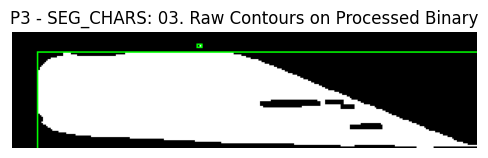

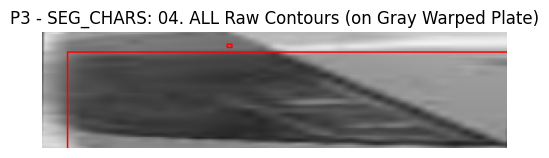


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=16 y=13 w=284 h=62 area=17608 asp=4.58
    Contour 0 FAILED filters:
      FAIL max_w: 284.00 > 120.00
      FAIL max_asp: 4.58 > 4.50
      FAIL max_area: 17608.00 > 4500.00
  Raw Contour 1: x=119 y=8 w=3 h=2 area=6 asp=1.50
    Contour 1 FAILED filters:
      FAIL min_h: 2.00 < 18.75
      FAIL min_area: 6.00 < 112.50
Segment Characters: Found 0 candidate characters after filtering.
--- End Debugging segment_characters for Plate 3 ---

Plate 4 (Detailed OCR): No characters segmented.


<Figure size 640x480 with 0 Axes>

--- Plate 4 Final Recognized Text:  ---
----------------------------------------


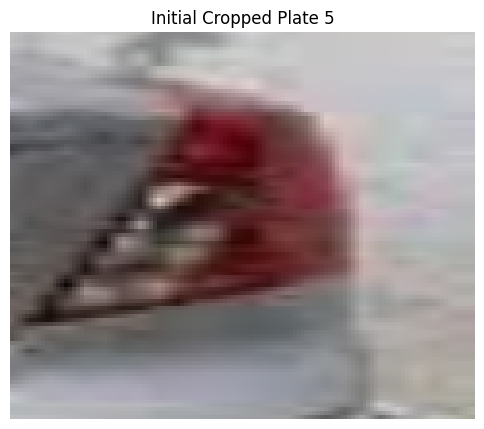


--- Debugging segment_characters for Plate 4 ---
Segment Characters: Performing binarization...


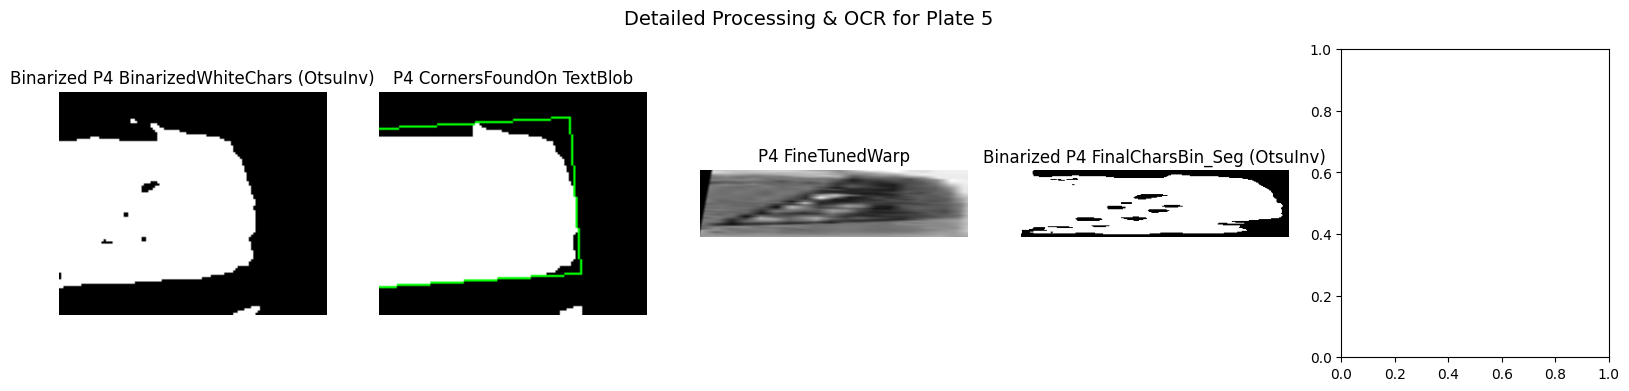

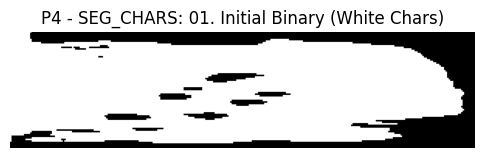

Segment Characters: Eroding with kernel (5,2), iterations: 2


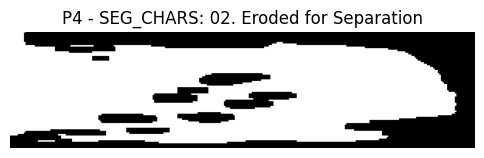

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 3 raw contours.


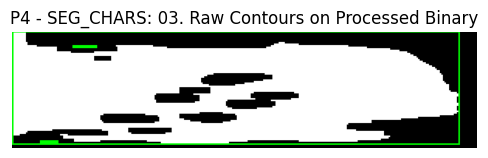

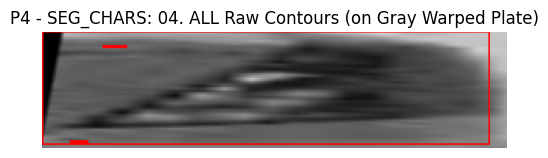


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=18 y=70 w=11 h=1 area=11 asp=11.00
    Contour 0 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL max_asp: 11.00 > 4.50
      FAIL min_area: 11.00 < 112.50
  Raw Contour 1: x=39 y=9 w=15 h=1 area=15 asp=15.00
    Contour 1 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL max_asp: 15.00 > 4.50
      FAIL min_area: 15.00 < 112.50
  Raw Contour 2: x=0 y=0 w=288 h=72 area=20736 asp=4.00
    Contour 2 FAILED filters:
      FAIL max_h: 72.00 > 67.50
      FAIL max_w: 288.00 > 120.00
      FAIL max_area: 20736.00 > 4500.00
Segment Characters: Found 0 candidate characters after filtering.
--- End Debugging segment_characters for Plate 4 ---

Plate 5 (Detailed OCR):

<Figure size 640x480 with 0 Axes>

--- Plate 5 Final Recognized Text:  ---
----------------------------------------


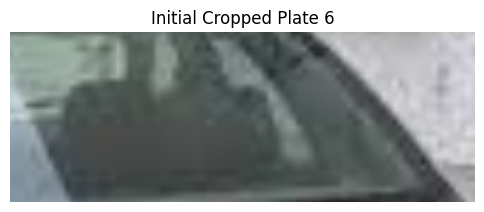


--- Debugging segment_characters for Plate 5 ---
Segment Characters: Performing binarization...


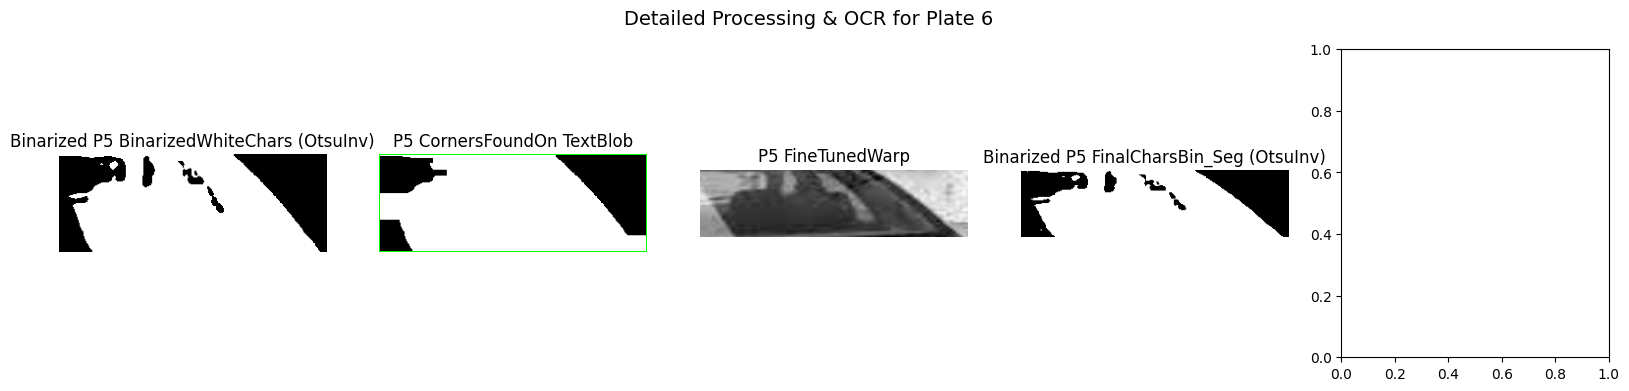

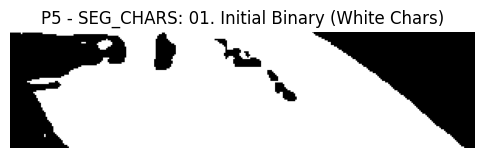

Segment Characters: Eroding with kernel (5,2), iterations: 2


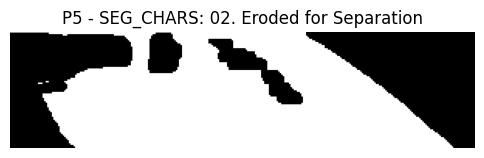

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 3 raw contours.


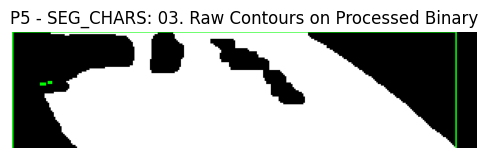

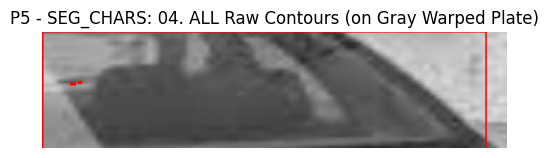


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=18 y=33 w=3 h=1 area=3 asp=3.00
    Contour 0 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL min_area: 3.00 < 112.50
  Raw Contour 1: x=23 y=32 w=2 h=1 area=2 asp=2.00
    Contour 1 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL min_area: 2.00 < 112.50
  Raw Contour 2: x=0 y=0 w=286 h=75 area=21450 asp=3.81
    Contour 2 FAILED filters:
      FAIL max_h: 75.00 > 67.50
      FAIL max_w: 286.00 > 120.00
      FAIL max_area: 21450.00 > 4500.00
Segment Characters: Found 0 candidate characters after filtering.
--- End Debugging segment_characters for Plate 5 ---

Plate 6 (Detailed OCR): No characters segmented.


<Figure size 640x480 with 0 Axes>

--- Plate 6 Final Recognized Text:  ---
----------------------------------------


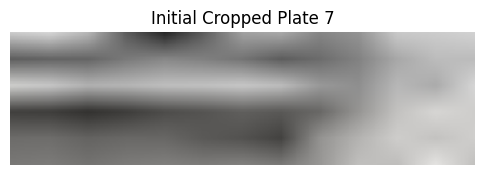


--- Debugging segment_characters for Plate 6 ---
Segment Characters: Performing binarization...


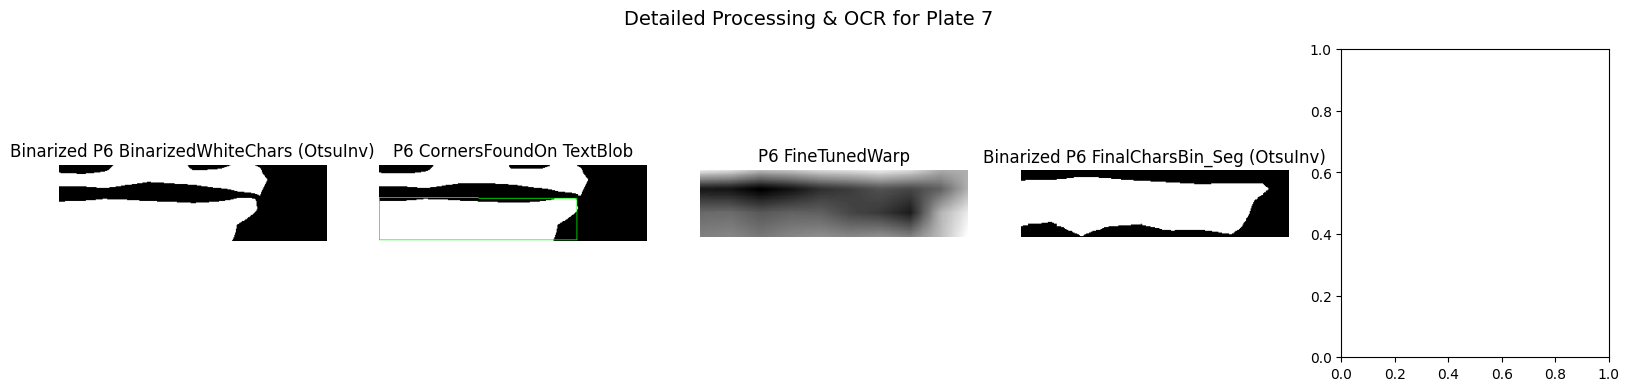

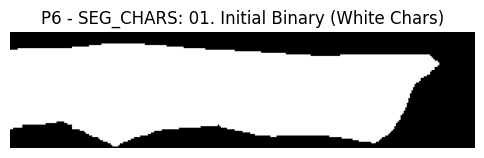

Segment Characters: Eroding with kernel (5,2), iterations: 2


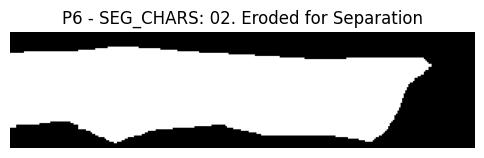

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 1 raw contours.


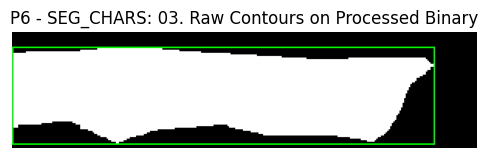

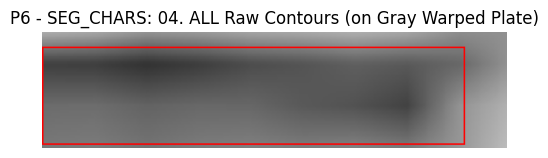


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=0 y=10 w=272 h=62 area=16864 asp=4.39
    Contour 0 FAILED filters:
      FAIL max_w: 272.00 > 120.00
      FAIL max_area: 16864.00 > 4500.00
Segment Characters: Found 0 candidate characters after filtering.
--- End Debugging segment_characters for Plate 6 ---

Plate 7 (Detailed OCR): No characters segmented.


<Figure size 640x480 with 0 Axes>

--- Plate 7 Final Recognized Text:  ---
----------------------------------------


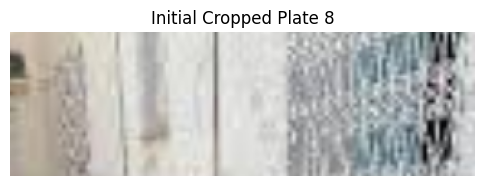


--- Debugging segment_characters for Plate 7 ---
Segment Characters: Performing binarization...


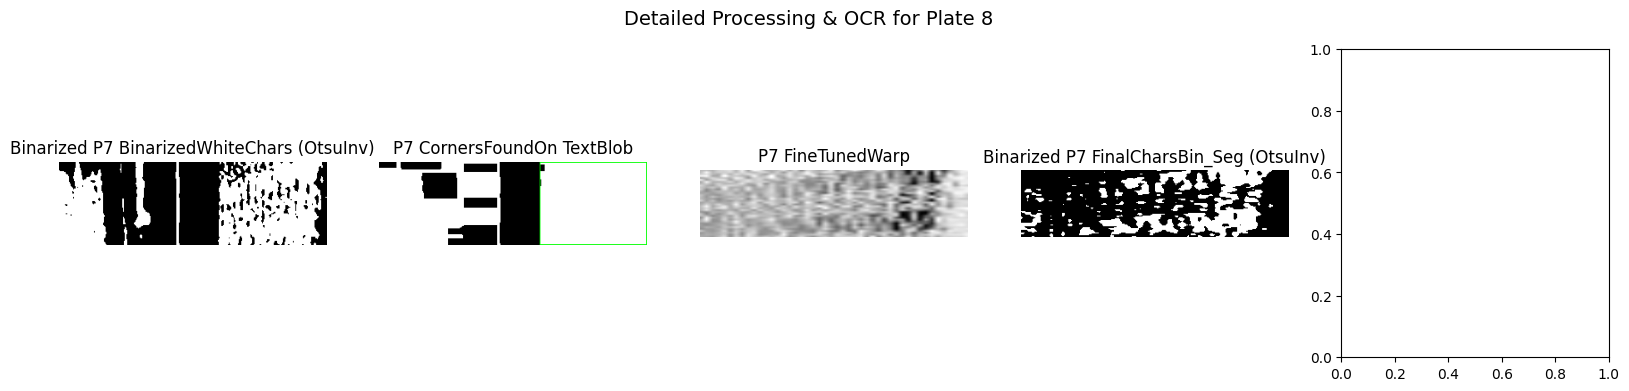

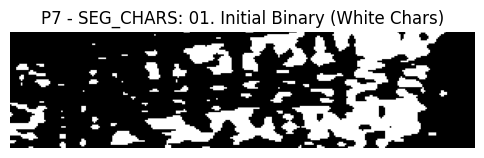

Segment Characters: Eroding with kernel (5,2), iterations: 2


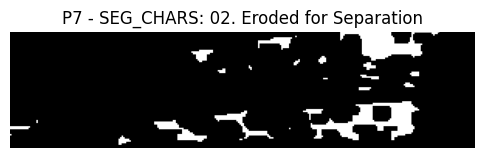

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 24 raw contours.


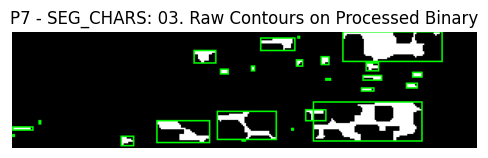

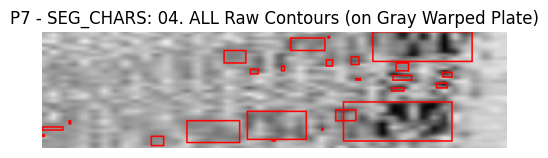


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=148 y=69 w=2 h=1 area=2 asp=2.00
    Contour 0 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL min_area: 2.00 < 112.50
  Raw Contour 1: x=70 y=67 w=8 h=6 area=48 asp=1.33
    Contour 1 FAILED filters:
      FAIL min_h: 6.00 < 18.75
      FAIL min_area: 48.00 < 112.50
  Raw Contour 2: x=0 y=66 w=1 h=1 area=1 asp=1.00
    Contour 2 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL min_area: 1.00 < 112.50
  Raw Contour 3: x=180 y=62 w=1 h=1 area=1 asp=1.00
    Contour 3 FAILED filters:
      FAIL min_h: 1.00 < 18.75
      FAIL min_area: 1.00 < 112.50
  Raw Contour 4: x=0 y=61 w=13 h=2 area=26 asp=6.50
    Contour 4 FAILED filters:
      FAIL min_h: 2.00 < 18.7

<Figure size 640x480 with 0 Axes>

--- Plate 8 Final Recognized Text: 88 ---
----------------------------------------


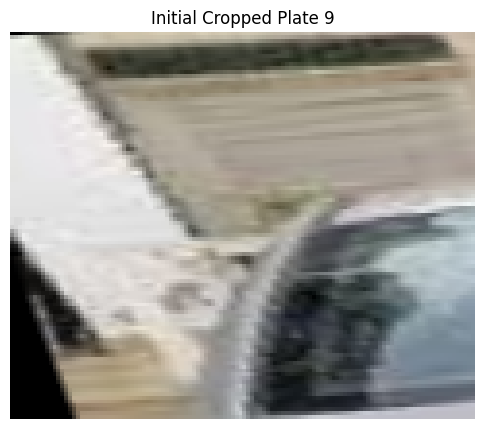


--- Debugging segment_characters for Plate 8 ---
Segment Characters: Performing binarization...


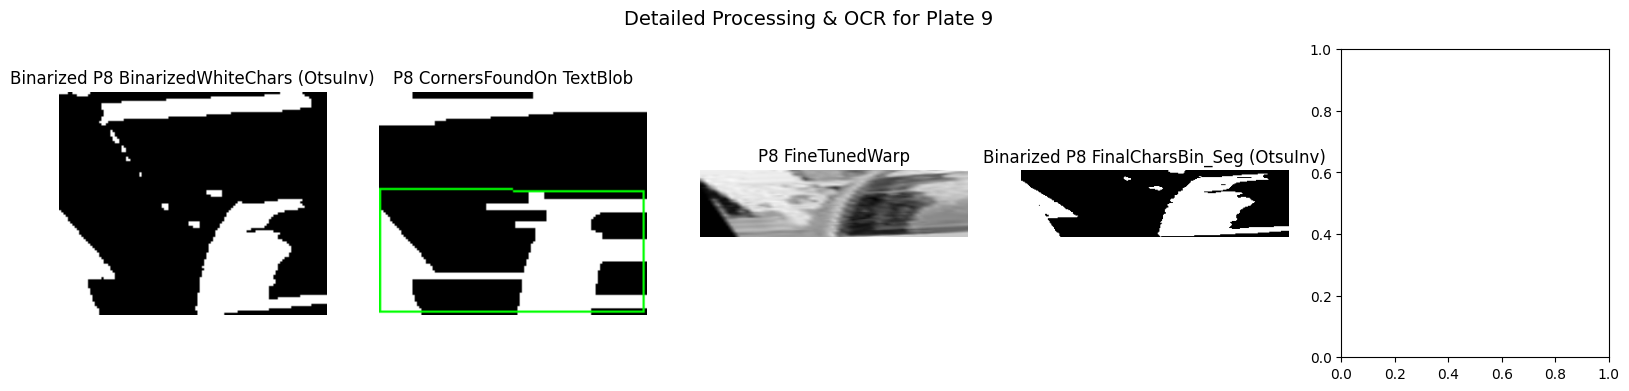

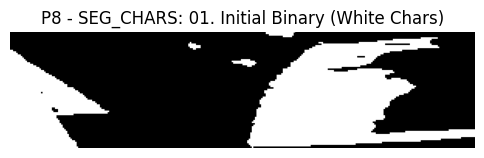

Segment Characters: Eroding with kernel (5,2), iterations: 2


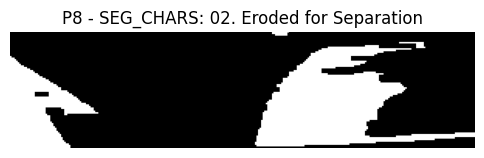

Segment Characters: Finding contours on processed_binary_chars...
Segment Characters: Found 4 raw contours.


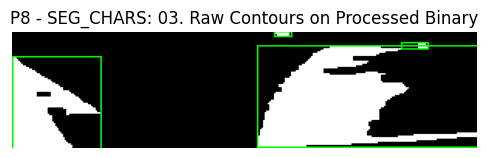

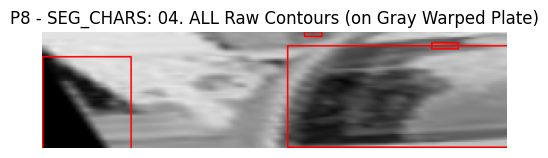


Segment Characters: Current Filtering Parameters (Re-evaluate these!):
  Plate Dims (H,W) for filters: (75, 300)
  Area (min,max): (112.50, 4500.00)
  Height (min,max): (18.75, 67.50)
  Aspect (min,max): (0.10, 4.50)
  Max Indiv. Width: 120.00
----------------------------------------------------
  Raw Contour 0: x=0 y=16 w=57 h=59 area=3363 asp=0.97
    Contour 0 PASSED filters. Adding.
  Raw Contour 1: x=158 y=9 w=142 h=65 area=9230 asp=2.18
    Contour 1 FAILED filters:
      FAIL max_w: 142.00 > 120.00
      FAIL max_area: 9230.00 > 4500.00
  Raw Contour 2: x=251 y=7 w=17 h=4 area=68 asp=4.25
    Contour 2 FAILED filters:
      FAIL min_h: 4.00 < 18.75
      FAIL min_area: 68.00 < 112.50
  Raw Contour 3: x=169 y=0 w=11 h=3 area=33 asp=3.67
    Contour 3 FAILED filters:
      FAIL min_h: 3.00 < 18.75
      FAIL min_area: 33.00 < 112.50
Segment Characters: Found 1 candidate characters after filtering.
--- End Debugging segment_characters for Plate 8 ---

Plate 9 (Detailed OCR): Found

<Figure size 640x480 with 0 Axes>

--- Plate 9 Final Recognized Text: 5 ---
----------------------------------------


In [10]:
if __name__ == "__main__":
    # --- CHOOSE ACTION ---
    # Step 1: Train the model using your character dataset
    ACTION = "PREDICT_PLATE" 
    
    # Step 2: After training, change to PREDICT_PLATE and run again
    # ACTION = "PREDICT_PLATE" 
    # --- END CHOOSE ACTION ---

    char_svm_model, char_label_encoder = None, None

    if ACTION == "TRAIN_CHAR_OCR":
        if not os.path.exists(CHAR_DATASET_PATH) or not os.listdir(CHAR_DATASET_PATH):
            print(f"ERROR: Dataset '{CHAR_DATASET_PATH}' empty or does not exist. Please create and populate it."); 
            # In a notebook, we might not exit but just print the error.
            # exit() 
        else:
            char_svm_model,char_label_encoder = train_char_ocr_model(CHAR_DATASET_PATH)
            if char_svm_model is None: 
                print("Character SVM Model training failed.")
            else:
                print("\n--- Training Complete. Set ACTION = 'PREDICT_PLATE' to use the model. ---")
        # In a notebook, you'd typically run the training cell, then modify ACTION in this cell and re-run.

    elif ACTION == "PREDICT_PLATE":
        char_svm_model,char_label_encoder = load_char_ocr_model_and_encoder()
        if char_svm_model is None or char_label_encoder is None:
            print("Could not load Character SVM model or LabelEncoder. Please run with ACTION = 'TRAIN_CHAR_OCR' first.")
        else:
            image_file_path = "Plates/plat16.jfif" # Or any other plate image
            enable_debug_plots = True # Set to False for less verbose output during prediction runs

            print(f"\n--- Predicting on image: {image_file_path} ---")
            full_image = cv2.imread(image_file_path)
            if full_image is None: 
                print(f"Error reading image: {image_file_path}")
            else:
                if enable_debug_plots: display_image(full_image, f"Original Full Scene: {os.path.basename(image_file_path)}")

                cropped_plate_bgr_images = detect_and_crop_plates(full_image, debug=enable_debug_plots)
                print(f"\nDetected {len(cropped_plate_bgr_images)} potential plate(s).\n")

                for i, plate_bgr_crop in enumerate(cropped_plate_bgr_images):
                    if enable_debug_plots: display_image(plate_bgr_crop, f"Initial Cropped Plate {i+1}")
                    
                    recognized_plate_text, _ = process_and_ocr_plate(
                        plate_bgr_crop, plate_idx=i, debug=enable_debug_plots,
                        svm_model=char_svm_model, label_encoder=char_label_encoder )
                    print(f"--- Plate {i+1} Final Recognized Text: {recognized_plate_text} ---")
                    print("-" * 40)
                
                if enable_debug_plots and not cropped_plate_bgr_images:
                     print("No plates detected to process for OCR.")

                # Ensure all plots generated during this prediction run are shown
                if enable_debug_plots:
                    plt.show() 
    else: 
        print(f"Unknown action: {ACTION}. Choose 'TRAIN_CHAR_OCR' or 'PREDICT_PLATE'.")